# Limpieza de datos

## Acerca de los datos
En este notebook, utilizaremos datos diarios de temperatura de la API [National Centers for Environmental Information (NCEI) API](https://www.ncdc.noaa.gov/cdo-web/webservices/v2). Utilizaremos el conjunto de datos Global Historical Climatology Network - Daily (GHCND); consulte la documentación [aquí](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf).

Estos datos se recogieron en la estación del aeropuerto LaGuardia de Nueva York para octubre de 2018. Contiene:
- la temperatura mínima diaria (`TMIN`)
- la temperatura máxima diaria (`TMAX`)
- la temperatura media diaria (`TAVG`)

*Nota: El NCEI forma parte de la Administración Nacional Oceánica y Atmosférica (NOAA) y, como puede ver en la URL de la API, este recurso se creó cuando el NCEI se llamaba NCDC. Si la URL de este recurso cambiara en el futuro, puede buscar "NCEI weather API" para encontrar la actualizada.*

Además, utilizaremos datos del mercado de valores S&P 500 (obtenidos mediante el paquete [`stock_analysis`](https://github.com/stefmolin/stock-analysis) que construiremos en el capítulo 7) y datos para bitcoin de 2017 a 2018. En la primera edición, los datos de bitcoin se recopilaron de CoinMarketCap utilizando el paquete `stock_analysis`; sin embargo, los cambios en el sitio web obligaron a cambiar la fuente de datos a Yahoo! Finance. Los datos de bitcoin que se recopilaron antes del cambio de sitio web de CoinMarketCap deberían ser equivalentes a los datos históricos que se pueden ver en [esta](https://coinmarketcap.com/currencies/bitcoin/historical-data/) página.

## Configuración
Necesitamos importar `pandas` y leer los datos de temperatura para empezar:

In [1]:
import pandas as pd

df = pd.read_csv('data/nyc_temperatures.csv')
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
1,2018-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2,2018-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
3,2018-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
4,2018-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


## Renombrar Columnas
Comenzamos con las siguientes columnas:

In [2]:
df.columns

Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')

Queremos renombrar la columna `value` para indicar que contiene la temperatura en grados Celsius y la columna `attributes` para decir `flags` ya que cada valor de la cadena delimitada por comas es una bandera diferente sobre la recogida de datos. Para esta tarea, utilizamos el método `rename()` y pasamos un diccionario que asigna los nombres de las columnas a sus nuevos nombres. Pasamos `inplace=True` para cambiar nuestro marco de datos original en lugar de obtener uno nuevo:

In [3]:
df.rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }, inplace=True # si no no se renombra cuando lo vuelva a llamar
)

Estas columnas se han renombrado correctamente:

In [4]:
df.columns

Index(['date', 'datatype', 'station', 'flags', 'temp_C'], dtype='object')

También podemos realizar operaciones de cadena sobre los nombres de las columnas con `rename()`:

In [5]:
df.rename(str.upper, axis='columns').columns

Index(['DATE', 'DATATYPE', 'STATION', 'FLAGS', 'TEMP_C'], dtype='object')

## Conversión de tipos
La columna `date` no se almacena actualmente como `datetime`:

In [6]:
df.dtypes

date         object
datatype     object
station      object
flags        object
temp_C      float64
dtype: object

Realicemos la conversión con `pd.to_datetime()`:

In [10]:
df['date'] = pd.to_datetime(df.date)
df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
dtype: object

Ahora obtendremos información útil cuando utilicemos `describe()` en esta columna:

In [11]:
df.date.describe()

count                     93
mean     2018-10-16 00:00:00
min      2018-10-01 00:00:00
25%      2018-10-08 00:00:00
50%      2018-10-16 00:00:00
75%      2018-10-24 00:00:00
max      2018-10-31 00:00:00
Name: date, dtype: object

Podemos utilizar `tz_localize()` en un objeto `DatetimeIndex` para convertirlo a la zona horaria deseada:

In [13]:
pd.date_range(start='2018-10-25', periods=2, freq='D').tz_localize('EST')

DatetimeIndex(['2018-10-25 00:00:00-05:00', '2018-10-26 00:00:00-05:00'], dtype='datetime64[ns, EST]', freq=None)

Esto también funciona con objetos `Series`/`DataFrame` que tengan un índice de tipo `DatetimeIndex`. Vamos a leer en el CSV de nuevo para este ejemplo y establecer la columna "date" para ser el índice y se almacena como una fecha y hora:

In [14]:
eastern = pd.read_csv(
    'data/nyc_temperatures.csv', index_col='date', parse_dates=True
).tz_localize('EST')
eastern.head()

,datatype,station,attributes,value
date,,,,
2018-10-01 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 00:00:00-05:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


Podemos usar `tz_convert()` para convertir a otra zona horaria desde ahí. Si convertimos las fechas de Eastern a UTC, ahora serán a las 5 AM, ya que `pandas` utilizará los desfases para convertir:

In [15]:
eastern.tz_convert('UTC').head()

,datatype,station,attributes,value
date,,,,
2018-10-01 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 05:00:00+00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


También podemos cambiar el periodo del índice. Podríamos cambiar el periodo a mensual para facilitar la agregación posterior. (La agregación se tratará en el capítulo 4).

In [16]:
eastern.tz_localize(None).to_period('M').index

PeriodIndex(['2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-

Ahora obtenemos un objeto `PeriodIndex`, que podemos volver a convertir en un objeto `DatetimeIndex` con `to_timestamp()`:

In [ ]:
eastern.tz_localize(None).to_period('M').to_timestamp().index

Podemos utilizar el método `assign()` para trabajar con varias columnas a la vez (o crear nuevas). Como nuestra columna `date` ya ha sido convertida, necesitamos leer los datos de nuevo:

In [17]:
df = pd.read_csv('data/nyc_temperatures.csv').rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }
)

new_df = df.assign(
    date=pd.to_datetime(df.date),
    temp_F=(df.temp_C * 9/5) + 32
)
new_df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
temp_F             float64
dtype: object

La columna `date` tiene ahora fecha y hora y se ha añadido la columna `temp_F`:

In [18]:
new_df.head()

,date,datatype,station,flags,temp_C,temp_F
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,70.16
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,78.08
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,64.94
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,72.86
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,78.98


También podemos utilizar `astype()` para realizar conversiones. Vamos a crear columnas de la parte entera de las temperaturas en Celsius y Fahrenheit. Usaremos **funciones lambda** (introducidas por primera vez en *Capítulo 2, Trabajando con Pandas DataFrames*), de forma que podamos usar los valores que se están creando en la columna `temp_F` para calcular la columna `temp_F_entera`. Es muy común (y útil) usar funciones lambda con `assign()`:

In [19]:
df = df.assign(
    date=lambda x: pd.to_datetime(x.date),
    temp_C_whole=lambda x: x.temp_C.astype('int'),
    temp_F=lambda x: (x.temp_C * 9/5) + 32,
    temp_F_whole=lambda x: x.temp_F.astype('int')
)

df.head()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


Creación de categorías:

In [20]:
df_with_categories = df.assign(
    station=df.station.astype('category'),
    datatype=df.datatype.astype('category')
)
df_with_categories.dtypes

date            datetime64[ns]
datatype              category
station               category
flags                   object
temp_C                 float64
temp_C_whole             int32
temp_F                 float64
temp_F_whole             int32
dtype: object

In [21]:
df_with_categories.describe(include='category')

,datatype,station
count,93,93
unique,3,1
top,TAVG,GHCND:USW00014732
freq,31,93


Nuestras categorías no tienen orden, pero esto es algo que soporta `pandas`:

In [22]:
pd.Categorical(
    ['med', 'med', 'low', 'high'], 
    categories=['low', 'med', 'high'],
    ordered=True
)

['med', 'med', 'low', 'high']
Categories (3, object): ['low' < 'med' < 'high']

## Reordenación, reindexación y ordenación
Digamos que queremos encontrar los días que alcanzaron las temperaturas más altas en los datos meteorológicos; podemos ordenar nuestros valores por la columna `temp_C` con la mayor en la parte superior para encontrar esto:

In [23]:
df[df.datatype == 'TMAX'].sort_values(by='temp_C', ascending=False).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


Sin embargo, esto no es perfecto porque tenemos algunos empates, y no están ordenados de forma coherente. En el primer empate entre la 7ª y la 10ª, la fecha anterior aparece en primer lugar, pero ocurre lo contrario con el empate entre la 4ª y la 2ª. Podemos utilizar otras columnas para desempatar y especificar cómo ordenar cada una con `ascendente`. Rompamos los empates con la columna de fecha y mostremos las fechas anteriores antes que las posteriores:

In [24]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True]).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


Observe que el índice estaba desordenado en los 2 últimos resultados. En este caso, nuestro índice sólo almacena el número de fila en los datos originales, pero puede que no necesitemos hacer un seguimiento de esa información. En este caso, podemos pasar `ignore_index=True` para obtener un nuevo índice después de ordenar:

In [25]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True], ignore_index=True).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
1,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
2,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
3,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
5,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
6,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
8,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
9,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


Cuando sólo se buscan los n valores más grandes, en lugar de querer ordenar todos los datos, podemos utilizar `nlargest()`:

In [26]:
df[df.datatype == 'TAVG'].nlargest(n=10, columns='temp_C')

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
27,2018-10-10,TAVG,GHCND:USW00014732,"H,,S,",23.8,23,74.84,74
30,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
18,2018-10-07,TAVG,GHCND:USW00014732,"H,,S,",22.8,22,73.04,73
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
6,2018-10-03,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
24,2018-10-09,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
9,2018-10-04,TAVG,GHCND:USW00014732,"H,,S,",21.3,21,70.34,70
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
21,2018-10-08,TAVG,GHCND:USW00014732,"H,,S,",20.9,20,69.62,69
12,2018-10-05,TAVG,GHCND:USW00014732,"H,,S,",20.3,20,68.54,68


Utilizamos `nsmallest()` para los n valores más pequeños.

In [27]:
df.nsmallest(n=5, columns=['temp_C', 'date'])

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
65,2018-10-22,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
77,2018-10-26,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
62,2018-10-21,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
74,2018-10-25,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
53,2018-10-18,TMIN,GHCND:USW00014732,",,W,2400",6.7,6,44.06,44


El método `sample()` nos dará filas (o columnas con `axis=1`) al azar. Podemos proporcionar una semilla (`estado_aleatorio`) para hacer esto reproducible. El índice después de hacer esto está desordenado:

In [30]:
df.sample(5, random_state=0).index

Index([2, 30, 55, 16, 13], dtype='int64')

Podemos usar `sort_index()` para ordenarlo de nuevo:

In [ ]:
df.sample(5, random_state=0).sort_index().index

El método `sort_index()` también puede ordenar las columnas alfabéticamente:

In [32]:
df.sort_index(axis=1).head()

,datatype,date,flags,station,temp_C,temp_C_whole,temp_F,temp_F_whole
0,TAVG,2018-10-01,"H,,S,",GHCND:USW00014732,21.2,21,70.16,70
1,TMAX,2018-10-01,",,W,2400",GHCND:USW00014732,25.6,25,78.08,78
2,TMIN,2018-10-01,",,W,2400",GHCND:USW00014732,18.3,18,64.94,64
3,TAVG,2018-10-02,"H,,S,",GHCND:USW00014732,22.7,22,72.86,72
4,TMAX,2018-10-02,",,W,2400",GHCND:USW00014732,26.1,26,78.98,78


Esto puede facilitar la selección con `loc` para muchas columnas:

In [31]:
df.sort_index(axis=1).head().loc[:,'temp_C':'temp_F_whole']

,temp_C,temp_C_whole,temp_F,temp_F_whole
0,21.2,21,70.16,70
1,25.6,25,78.08,78
2,18.3,18,64.94,64
3,22.7,22,72.86,72
4,26.1,26,78.98,78


Debemos ordenar el índice para comparar dos marcos de datos. Si el índice es diferente, pero los datos son los mismos, se marcarán como no iguales:

In [33]:
df.equals(df.sort_values(by='temp_C'))

False

La ordenación del índice resuelve este problema:

In [34]:
df.equals(df.sort_values(by='temp_C').sort_index())

True

Fijemos la columna `date` como nuestro índice:

In [35]:
df.set_index('date', inplace=True)
df.head()

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


Ahora que tenemos un índice de tipo `DatetimeIndex`, podemos hacer el corte y la indexación datetime. Siempre que proporcionemos un formato de fecha que pandas entienda, podremos obtener los datos. Para seleccionar todo 2018, simplemente usamos `df.loc['2018']`, para el cuarto trimestre de 2018 podemos usar `df.loc['2018-Q4']`, coger octubre es tan simple como usar `df.loc['2018-10']`; estos también se pueden combinar para construir rangos. Tomemos desde el 11 de octubre de 2018 hasta el 12 de octubre de 2018 (incluidos ambos puntos finales)&mdash;tenga en cuenta que el uso de `loc[]` es opcional para los rangos:

In [36]:
df['2018-10-11':'2018-10-12']

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


También podemos usar `reset_index()` para obtener un índice nuevo y mover nuestro índice actual a una columna para guardarlo. Esto es especialmente útil si teníamos datos, como la fecha, en el índice que no queremos perder:

In [37]:
df['2018-10-11':'2018-10-12'].reset_index()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
1,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2,2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
3,2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
4,2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
5,2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


La reindexación nos permite conformar nuestro eje para que contenga un conjunto determinado de etiquetas. Veamos un ejemplo con los datos de las acciones del S&P 500 en el archivo `sp500.csv`. Observe que sólo tenemos datos de los días de negociación (días laborables, excepto festivos):

In [38]:
sp = pd.read_csv(
    'data/sp500.csv', index_col='date', parse_dates=True
).drop(columns=['adj_close'])

sp.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3770530000,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3764890000,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3761820000,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3339890000,Friday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3217610000,Monday
2017-01-10,2279.270020,2265.270020,2269.719971,2268.899902,3638790000,Tuesday
2017-01-11,2275.320068,2260.830078,2268.600098,2275.320068,3620410000,Wednesday
2017-01-12,2271.780029,2254.250000,2271.139893,2270.439941,3462130000,Thursday
2017-01-13,2278.679932,2271.510010,2272.739990,2274.639893,3081270000,Friday


Si queremos analizar el valor de una cartera (grupo de activos) que cotiza en días distintos, tenemos que gestionar el desajuste en el índice. Bitcoin, por ejemplo, cotiza diariamente. Si sumamos todos los datos que tenemos para cada día (las agregaciones se tratarán en el capítulo 4, así que no te fijes en esta parte), obtenemos lo siguiente:

In [39]:
bitcoin = pd.read_csv(
    'data/bitcoin.csv', index_col='date', parse_dates=True
).drop(columns=['market_cap'])

# precio de cierre de cada día = cierre del S&P 500 + cierre del Bitcoin (lo mismo para otras métricas)
portfolio = pd.concat([sp, bitcoin], sort=False).groupby(level='date').sum()

portfolio.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,1003.080000,958.700000,963.660000,998.330000,147775008,Sunday
2017-01-02,1031.390000,996.700000,998.620000,1021.750000,222184992,Monday
2017-01-03,3307.959883,3266.729883,3273.170068,3301.670078,3955698000,Tuesday
2017-01-04,3432.240068,3306.000098,3306.000098,3425.480000,4109835984,Wednesday
2017-01-05,3462.600000,3170.869951,3424.909932,3282.380000,4272019008,Thursday
2017-01-06,3328.910098,3148.000059,3285.379893,3179.179980,3691766000,Friday
2017-01-07,908.590000,823.560000,903.490000,908.590000,279550016,Saturday
2017-01-08,942.720000,887.250000,908.170000,911.200000,158715008,Sunday
2017-01-09,3189.179990,3148.709902,3186.830088,3171.729902,3359486992,Monday


Puede que no sea inmediatamente obvio lo que pasa con los datos anteriores, pero con una visualización podemos ver fácilmente el patrón cíclico de caídas en los días en que la bolsa está cerrada. (No te preocupes demasiado por el código de trazado, lo trataremos en profundidad en los capítulos 5 y 6).

Ahora necesitaremos importar `matplotlib`:

In [40]:
import matplotlib.pyplot as plt # usamos este módulo para trazar
from matplotlib.ticker import StrMethodFormatter # para formatear el eje

Now we can see why we need to reindex:

In [ ]:
# traza el precio de cierre desde el cuarto trimestre de 2017 hasta el segundo trimestre de 2018
ax = portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', figsize=(15, 5), legend=False,
    title="Bitcoin + valor del S&P 500 sin tener en cuenta los distintos índices"
)

# formato
ax.set_ylabel('price')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# mostrar el plot
plt.show()

Necesitamos alinear el índice del S&P 500 para que coincida con el bitcoin para solucionar esto. Usaremos el método `reindex()`, pero por defecto obtenemos `NaN` para los valores de los que no tenemos datos:

In [41]:
sp.reindex(bitcoin.index).head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,NaN,NaN,NaN,NaN,NaN,Saturday
2017-01-08,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


Así que ahora tenemos filas para cada día del año, pero todos los fines de semana y días festivos tienen valores `NaN`. Para solucionar esto, podemos especificar cómo tratar los valores que faltan con el argumento `method`. En este caso, lo que queremos es `forward-fill`, que pondrá los valores de los fines de semana y festivos como el valor que tenían el viernes (o al final de la semana comercial) anterior:

In [42]:
sp.reindex(bitcoin.index, method='ffill').head(10)\
    .assign(day_of_week=lambda x: x.index.day_name())

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Saturday
2017-01-08,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


Para aislar los cambios que se producen con el relleno hacia delante, podemos utilizar el método `compare()`. Nos muestra los valores que difieren entre marcos de datos etiquetados de forma idéntica (mismos nombres y mismas columnas). Aquí, podemos ver que solo los fines de semana y los días festivos (el lunes 16 de enero de 2017 fue el día de MLK) tienen valores rellenados hacia adelante. Observe que los días consecutivos tienen los mismos valores.

In [44]:
sp.reindex(bitcoin.index)\
    .compare(sp.reindex(bitcoin.index, method='ffill'))\
    .head(10).assign(day_of_week=lambda x: x.index.day_name())

high               low              open              close  \
           self        other self        other self        other  self   
date                                                                     
2017-01-07  NaN  2282.100098  NaN  2264.060059  NaN  2271.139893   NaN   
2017-01-08  NaN  2282.100098  NaN  2264.060059  NaN  2271.139893   NaN   
2017-01-14  NaN  2278.679932  NaN  2271.510010  NaN  2272.739990   NaN   
2017-01-15  NaN  2278.679932  NaN  2271.510010  NaN  2272.739990   NaN   
2017-01-16  NaN  2278.679932  NaN  2271.510010  NaN  2272.739990   NaN   
2017-01-21  NaN  2276.959961  NaN  2265.010010  NaN  2269.959961   NaN   
2017-01-22  NaN  2276.959961  NaN  2265.010010  NaN  2269.959961   NaN   
2017-01-28  NaN  2299.020020  NaN  2291.620117  NaN  2299.020020   NaN   
2017-01-29  NaN  2299.020020  NaN  2291.620117  NaN  2299.020020   NaN   
2017-02-04  NaN  2298.310059  NaN  2287.879883  NaN  2288.540039   NaN   

                        volume               day_of_week  
                  other   self         other              
date                                                      
2017-01-07  2276.979980    NaN  3.339890e+09    Saturday  
2017-01-08  2276.979980    NaN  3.339890e+09      Sunday  
2017-01-14  2274.639893    NaN  3.081270e+09    Saturday  
2017-01-15  2274.639893    NaN  3.081270e+09      Sunday  
2017-01-16  2274.639893    NaN  3.081270e+09      Monday  
2017-01-21  2271.310059    NaN  3.524970e+09    Saturday  
2017-01-22  2271.310059    NaN  3.524970e+09      Sunday  
2017-01-28  2294.689941    NaN  3.135890e+09    Saturday  
2017-01-29  2294.689941    NaN  3.135890e+09      Sunday  
2017-02-04  2297.419922    NaN  3.597970e+09    Saturday

Sin embargo, esto no es perfecto. Probablemente queramos 0 para el volumen negociado y poner el precio de cierre para la apertura, el máximo, el mínimo y el cierre en los días en que el mercado está cerrado:

In [45]:
import numpy as np

sp_reindexed = sp.reindex(bitcoin.index).assign(
    volume=lambda x: x.volume.fillna(0), # poner 0 cuando el mercado está cerrado
    close=lambda x: x.close.fillna(method='ffill'), # llevar esto adelante
    # tomar el precio de cierre si no están disponibles
    open=lambda x: np.where(x.open.isnull(), x.close, x.open),
    high=lambda x: np.where(x.high.isnull(), x.close, x.high),
    low=lambda x: np.where(x.low.isnull(), x.close, x.low)
)
sp_reindexed.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

C:\Users\Sol\AppData\Local\Temp\ipykernel_3092\3073622216.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close=lambda x: x.close.fillna(method='ffill'), # llevar esto adelante


,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,0.000000e+00,Sunday
2017-01-02,NaN,NaN,NaN,NaN,0.000000e+00,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Saturday
2017-01-08,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


Si creamos una visualización comparando los datos reindexados con el primer intento, vemos cómo la reindexación ayudó a mantener el valor del activo cuando el mercado estaba cerrado:

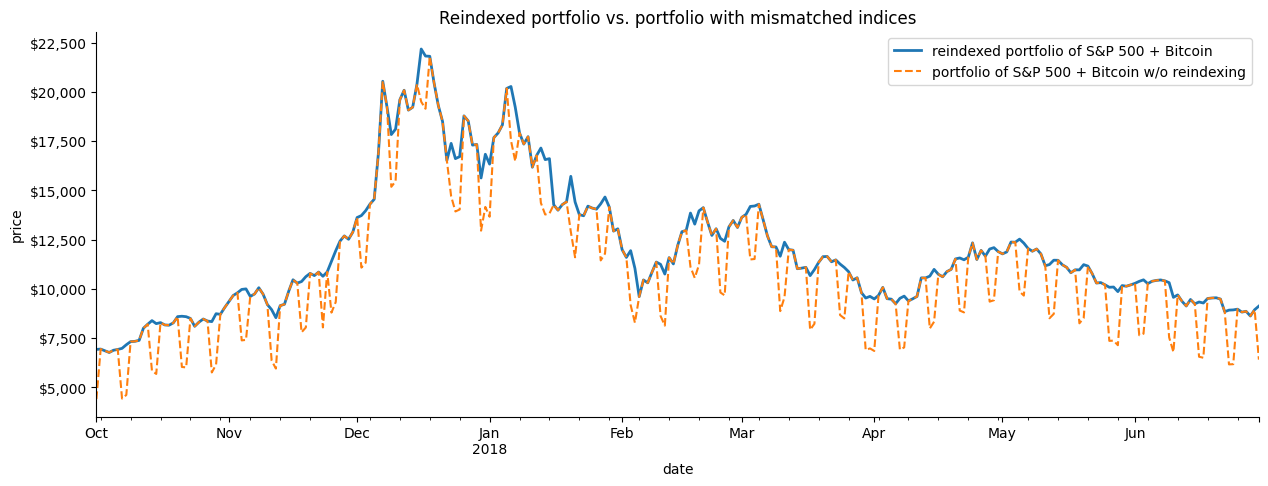

In [46]:
# precio de cierre de cada día = cierre del S&P 500 ajustado al cierre del mercado + cierre del Bitcoin (lo mismo para otras métricas)
fixed_portfolio = sp_reindexed + bitcoin

# Traza el precio de cierre de la cartera reindexada desde el cuarto trimestre de 2017 hasta el segundo trimestre de 2018.
ax = fixed_portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', label='reindexed portfolio of S&P 500 + Bitcoin', figsize=(15, 5), linewidth=2, 
    title='Reindexed portfolio vs. portfolio with mismatched indices'
)

# añadir línea para la cartera original para comparación
portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', ax=ax, linestyle='--', label='portfolio of S&P 500 + Bitcoin w/o reindexing'
)

# formateo
ax.set_ylabel('price')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# mostrar el plot
plt.show()

<hr>
<div>
    <a href="./2-usando_la_api_weather.ipynb">
        <button>&#8592; Notebook Anterior</button>
    </a>
    <a href="./4-reshaping_data.ipynb">
        <button style="float: right;"> Siguiente Notebook &#8594;</button>
    </a>
</div>
<hr>